In [6]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [7]:
try: 
  %tensorflow 2.x
except:
  pass

In [39]:
import json
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
DATASET_NAME = "sarcasm.json"
BASE_URL = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com"
path_pwd = !pwd
BASE_PATH = os.path.join(path_pwd[0], 'datasets')

In [41]:
!mkdir -p $BASE_PATH
print(BASE_PATH)

/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets


In [42]:
full_url = os.path.join(BASE_URL, DATASET_NAME)
dataset_path = os.path.join(BASE_PATH, DATASET_NAME)

In [43]:
# Download dataset
!wget --no-check-certificate $full_url -O $dataset_path

--2019-12-09 20:49:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets/sarcasm.json’

/home/laura/data/nl 100%[===================>]   5.38M  15.8MB/s    in 0.3s    

2019-12-09 20:49:46 (15.8 MB/s) - ‘/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets/sarcasm.json’ saved [5643545/5643545]



In [44]:
# Define params 
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [45]:
# Open the file and read it
with open(dataset_path, 'r') as f:
    datastore = json.load(f)

In [46]:
sentences = []
labels = []

# Split into the headline and the label
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [47]:
# Split the dataset between training and testing 
training_sentences, training_labels = sentences[0:training_size], np.array(labels[0:training_size])
testing_sentences, testing_labels = sentences[training_size:], np.array(labels[training_size:])

In [48]:
# Create the tokenizer with vocab size 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [49]:
# Generate the tokens for the words in training 
tokenizer.fit_on_texts(training_sentences)

# Get the word index
word_index = tokenizer.word_index

In [50]:
# Generate the sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# Add the padding to sequences using post
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [51]:
# Generate sequences for testing sentences and its padding 
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [57]:
# Create the model using CONV1D 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [58]:
# Configure the model 
metric = 'accuracy' 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[metric])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
dropout (Dropout)            (None, 116, 128)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
__________________________________________________

In [59]:
# Train the model 
num_epochs = 30
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 [==============================] - 4s 188us/sample - loss: 0.4691 - accuracy: 0.7643 - val_loss: 0.4067 - val_accuracy: 0.8114
Epoch 2/30
20000/20000 [==============================] - 3s 160us/sample - loss: 0.3582 - accuracy: 0.8385 - val_loss: 0.3879 - val_accuracy: 0.8247
Epoch 3/30
20000/20000 [==============================] - 4s 181us/sample - loss: 0.3232 - accuracy: 0.8572 - val_loss: 0.3881 - val_accuracy: 0.8225
Epoch 4/30
20000/20000 [==============================] - 3s 157us/sample - loss: 0.2941 - accuracy: 0.8725 - val_loss: 0.3962 - val_accuracy: 0.8195
Epoch 5/30
20000/20000 [==============================] - 3s 147us/sample - loss: 0.2665 - accuracy: 0.8849 - val_loss: 0.4333 - val_accuracy: 0.8132
Epoch 6/30
20000/20000 [==============================] - 3s 143us/sample - loss: 0.2381 - accuracy: 0.8998 - val_loss: 0.4249 - val_accuracy: 0.8196
Epoch 7/30
20000/20000 [===========================

In [60]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

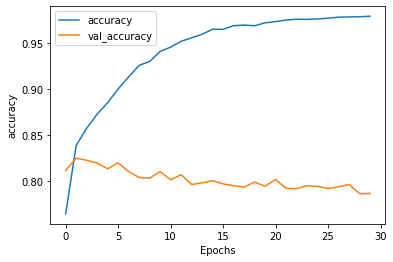

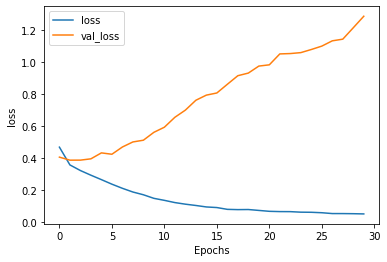

In [61]:
plot_graphs(history, metric)
plot_graphs(history, 'loss')

In [62]:
path_to_save_model = os.path.join(BASE_PATH, "sarcasm_conv1d.h5")
model.save(path_to_save_model)

In [63]:
session.close()